In [ ]:
!pip install yfinance

In [69]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


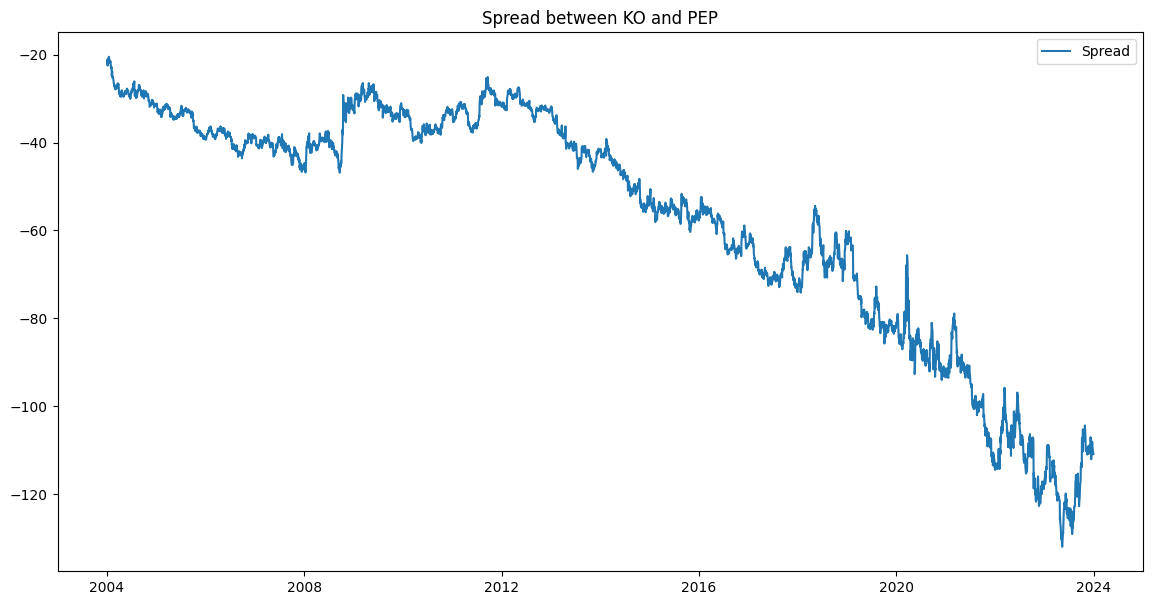

In [74]:
# User input for stock tickers
stock1 = 'KO' # enter your first ticker
stock2 = 'PEP' # enter your second ticker
start_date = '2004-01-01'
end_date = '2024-01-01'

# Fetch historical data
data1 = yf.download(stock1, start=start_date, end=end_date)
data2 = yf.download(stock2, start=start_date, end=end_date)

# Calculate the spread
spread = data1['Close'] - data2['Close']

# Plot the spread
plt.figure(figsize=(14, 7))
plt.plot(spread, label='Spread')
plt.title(f'Spread between {stock1} and {stock2}')
plt.legend()
plt.show()

The spread is non-stationary: it is moving down over time rather than staying in place.  
How about a moving average?

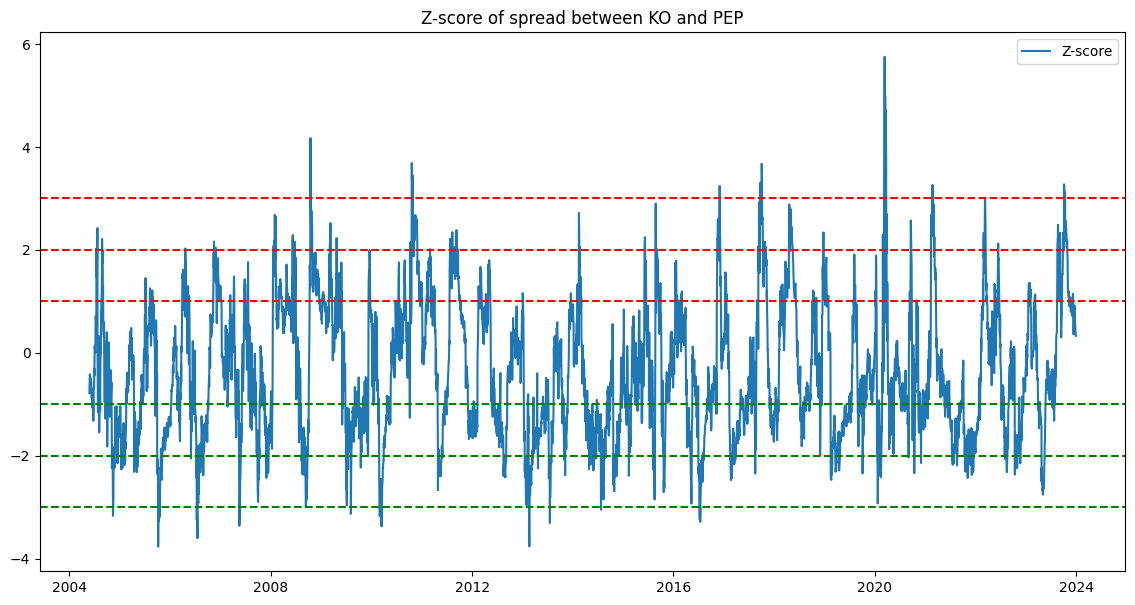

In [75]:
# generate moving average of spread
window = 100
spread_mean = spread.rolling(window=window).mean()
spread_std = spread.rolling(window=window).std()

# find difference between spread and moving average
z_score = (spread - spread_mean) / spread_std

# Plot the z-score
plt.figure(figsize=(14, 7))
plt.plot(z_score, label='Z-score')
plt.axhline(1.0, color='r', linestyle='--')
plt.axhline(2.0, color='r', linestyle='--')
plt.axhline(3.0, color='r', linestyle='--')

plt.axhline(-1.0, color='g', linestyle='--')
plt.axhline(-2.0, color='g', linestyle='--')
plt.axhline(-3.0, color='g', linestyle='--')

plt.title(f'Z-score of spread between {stock1} and {stock2}')
plt.legend()
plt.show()

In [76]:
z_score[z_score<-3]

Date
2004-11-12   -3.165393
2005-10-05   -3.221468
2005-10-06   -3.765978
2005-10-07   -3.279990
2005-10-10   -3.048332
2005-10-12   -3.267838
2005-10-18   -3.187628
2006-07-13   -3.250359
2006-07-14   -3.012180
2006-07-17   -3.315468
2006-07-18   -3.597892
2007-05-18   -3.357906
2007-05-21   -3.079726
2008-09-12   -3.002274
2009-08-04   -3.126955
2010-03-01   -3.042619
2010-03-02   -3.173759
2010-03-12   -3.007385
2010-03-15   -3.369839
2010-03-16   -3.110230
2010-03-17   -3.167053
2013-02-19   -3.757059
2013-02-20   -3.391163
2013-02-21   -3.153317
2013-07-18   -3.303135
2014-07-24   -3.047549
2016-07-07   -3.103709
2016-07-08   -3.204833
2016-07-11   -3.247333
2016-07-13   -3.283196
2016-07-14   -3.134382
Name: Close, dtype: float64

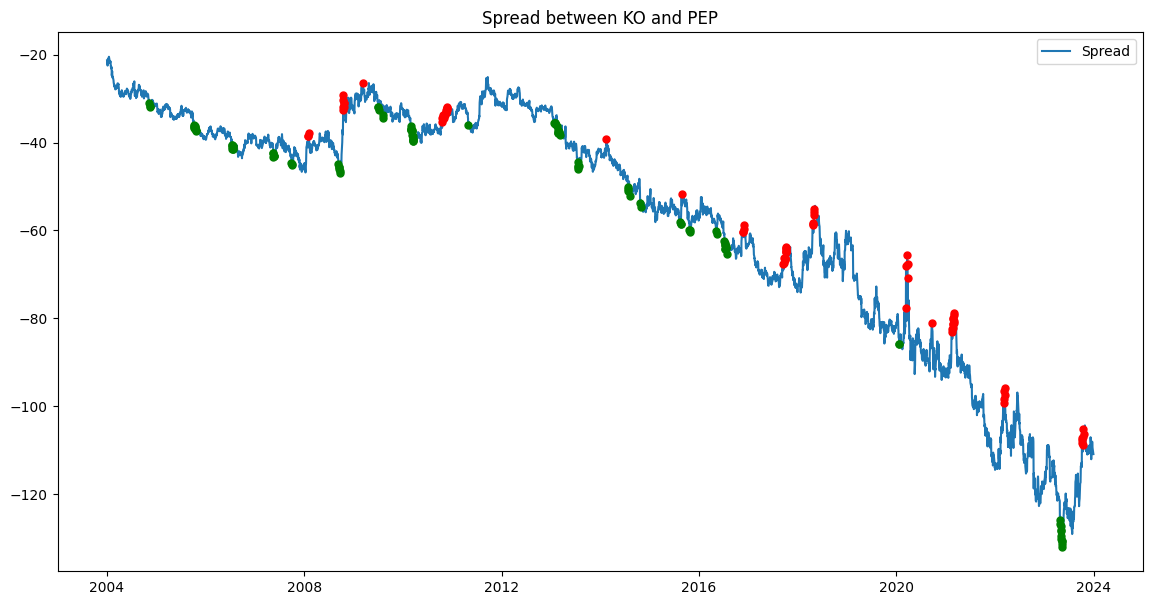

In [87]:
# plot spread again but with dots when z-score is above 2 or below -2
plot_thresh = 2.5
plt.figure(figsize=(14, 7))
plt.plot(spread, label='Spread')
plt.plot(spread[z_score > plot_thresh], 'ro', markersize=5)
plt.plot(spread[z_score < -plot_thresh], 'go', markersize=5)
plt.title(f'Spread between {stock1} and {stock2}')
plt.legend()
plt.show()

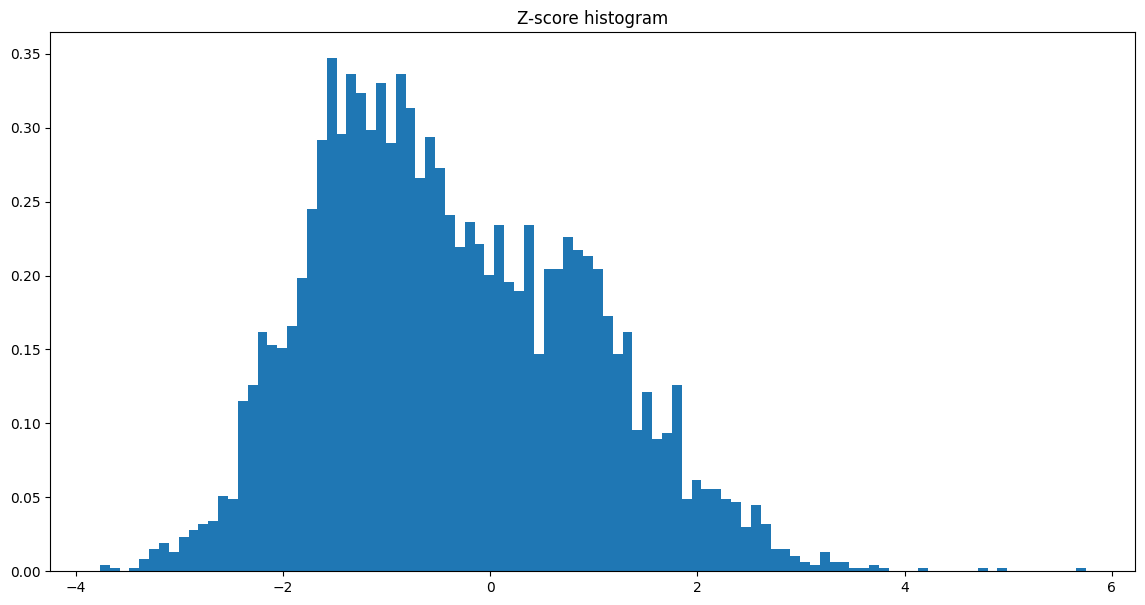

In [88]:
# plot z score histogram
plt.figure(figsize=(14, 7))
plt.hist(z_score.dropna(), bins=100, density=True)
plt.title('Z-score histogram')
plt.show()

Not super normal, why might this be? Could we get it better?

Shorting at -26.499998092651367
Exiting at -29.399999618530273
Shorting at -26.829999923706055
Exiting at -28.545000076293945
Longing at -30.529998779296875
Exiting at -36.275001525878906
Longing at -39.13999938964844
Exiting at -37.915000915527344
Shorting at -38.22500038146973
Exiting at -40.57999610900879
Longing at -42.26999855041504
Exiting at -40.04500198364258
Shorting at -39.79000282287598
Exiting at -40.075002670288086
Longing at -42.22500228881836
Exiting at -32.53500175476074
Shorting at -29.145000457763672
Exiting at -30.735000610351562
Shorting at -26.514999389648438
Exiting at -30.53999900817871
Longing at -31.93000030517578
Exiting at -35.7399959564209
Shorting at -35.24000358581543
Exiting at -35.32499694824219
Shorting at -30.75499725341797
Exiting at -33.119998931884766
Longing at -36.01499938964844
Exiting at -29.740001678466797
Shorting at -29.474998474121094
Exiting at -30.5
Longing at -34.03000259399414
Exiting at -39.159996032714844
Shorting at -40.0
Exiting at -

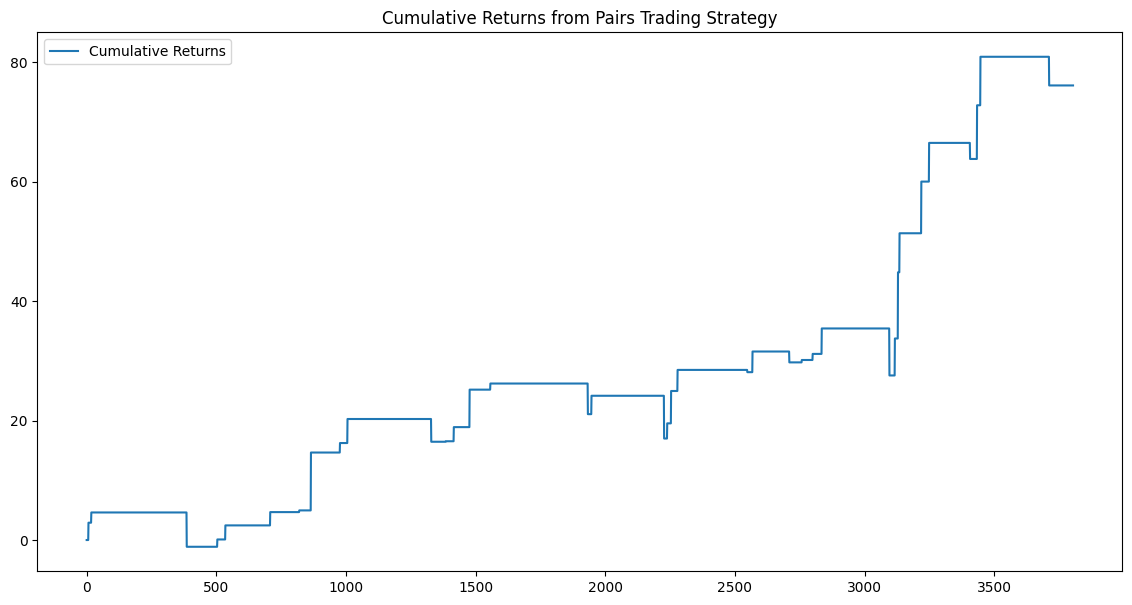

In [89]:
# Simulate trading strategies

# Define entry and exit points in terms of z score
entry_threshold = 2.
exit_threshold = 0

# Initialize positions and cash
positions = []
cash = 0


in_position = 0
in_value = 0
for i in range(len(z_score)):
    if z_score.iloc[i] > entry_threshold and in_position == 0:
        # short the spread
        in_position = -1
        in_value = spread.iloc[i]
        print(f'Shorting at {spread.iloc[i]}')
    elif z_score.iloc[i] < -entry_threshold and in_position == 0:
        # long the spread
        in_position = 1
        in_value = -spread.iloc[i]
        print(f'Longing at {spread.iloc[i]}')
    if in_position != 0:
        if in_position == -1 and z_score.iloc[i] < exit_threshold:
            # exit short position
            positions.append(in_value - spread.iloc[i])
            in_position = 0
            in_value = 0
            print(f'Exiting at {spread.iloc[i]}')
        elif in_position == 1 and z_score.iloc[i] > entry_threshold:
            # exit long position
            positions.append(in_value + spread.iloc[i])
            in_position = 0
            in_value = 0
            print(f'Exiting at {spread.iloc[i]}')
        else:
            positions.append(0)

positions = np.array(positions)
    

# Calculate cumulative returns
cumulative_returns = np.cumsum(positions)

# Plot cumulative returns
plt.figure(figsize=(14, 7))
plt.plot(cumulative_returns, label='Cumulative Returns')
plt.title('Cumulative Returns from Pairs Trading Strategy')
plt.legend()
plt.show()

## Extensions:
- Appropriate position sizing
- Appropriate returns
- Handling non-stationarity
- Stopping out?
- ...